# NLP with PyTorch + torchtext — example

This notebook contains an independent implementation inspired by the DataCamp article "NLP with PyTorch: A comprehensive guide" (https://www.datacamp.com/tutorial/nlp-with-pytorch-a-comprehensive-guide). The code here is an original implementation using torch + torchtext to train a simple neural network classifier on the AG_NEWS dataset.  While some of the necessary pytorch tools are now deprecated, this notebook will give you a practical introduction into the basics of training a model using pytorch.

**Note:** this notebook depends on torch==2.3.0 and torchtext==0.18.0.  Later versions of torch may be incompatible with torchtext.

In [13]:
# Optional: try to import torch and torchtext; if missing, attempt to install minimal packages

import sys
try:
    import torch, torchtext
    print("torch version:", torch.__version__)
    print("torchtext version:", torchtext.__version__)
except Exception as e:
    print("torch or torchtext import failed:\n", e)
    print("Attempting to install torchtext (and torch if feasible). This may take a while.")
    import subprocess
    cmd = [sys.executable, "-m", "pip", "install", "--upgrade", "pip"]
    subprocess.run(cmd, check=False)
    # Try to install torchtext and a CPU-compatible torch if not present
    subprocess.run([sys.executable, "-m", "pip", "install", "torchtext==0.18.0", "torch==2.3.0", "torchdata==0.9.0", "portalocker>=2.0.0"], check=False)    
    print("Install attempts finished. Restart the kernel or re-run this cell and imports.")

torch version: 2.3.0+cu121
torchtext version: 0.18.0+cpu


Import required Python libraries and set the compute device (CPU or CUDA). These include torch, torchtext, and utilities used later for building the dataset, model, and training loop.

In [14]:
# Imports
import os
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchtext
torchtext.disable_torchtext_deprecation_warning()
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print('Device:', device)

Device: cpu


Prepare tokenization and build the vocabulary from the training split of the AG_NEWS dataset. This cell also defines small helper pipelines to convert raw text and labels into numerical tensors used by the model. You may safely ignore any deprecation warnings.

In [15]:
# Prepare tokenizer, vocabulary and label mapping

tokenizer = get_tokenizer('basic_english')  # small, effective tokenizer

# Build vocabulary from the training splits

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Use streaming iterator to avoid loading everything in memory
train_iter = AG_NEWS(split='train')
# build vocab
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

num_tokens = len(vocab)
print('Vocab size:', num_tokens)

# Helper to map raw text -> tensor of token IDs
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1  # AG_NEWS labels are 1..4, convert to 0..3

Vocab size: 95811


Define the collate function used by the PyTorch DataLoader. The collate function converts a batch of raw examples into a packed format (flattened token tensor + offsets) suitable for an EmbeddingBag-based model, and converts labels to tensors.

In [16]:
# Collate function for DataLoader using EmbeddingBag-style batching

def collate_batch(batch):
    """
    Collate a list of (label, text) samples into the flattened tensors
    expected by `nn.EmbeddingBag`.

    Args:
        batch: list of tuples (label, text)
               - label: original dataset label (e.g., 1..4 for AG_NEWS)
               - text: raw string text

    Returns:
        text: 1D LongTensor containing concatenated token IDs for the whole batch
        offsets: 1D LongTensor where each element is the starting index of the
                 corresponding sample in `text` (used by EmbeddingBag)
        labels: 1D LongTensor of zero-based class indices

    Conceptual worked example (numbers):
        Suppose the tokenized & ID-mapped samples are:
          sample0 -> [10, 23, 5]   (length 3)
          sample1 -> [7, 12]       (length 2)
          sample2 -> [4, 9, 11, 2] (length 4)

        Building offsets as lengths yields offsets = [0, 3, 2, 4] (the last
        entry is the last sample length appended as a placeholder). We drop
        the trailing placeholder then cumsum:
          offsets[:-1] = [0, 3, 2]
          cumsum -> [0, 3, 5]

        Flattened text = [10,23,5, 7,12, 4,9,11,2]
        offsets = [0, 3, 5]
        Each sample's span within flattened text:
          sample0 -> flattened[0:3]  == [10,23,5]
          sample1 -> flattened[3:5]  == [7,12]
          sample2 -> flattened[5:9]  == [4,9,11,2]

    Important notes:
      - `offsets` length == batch_size. Each offsets[i] is the starting index
        in `text` for sample i.
      - EmbeddingBag takes (text, offsets) and for each offset returns an
        aggregated embedding for the corresponding segment (e.g. mean or sum).
      - When using DataLoader with `num_workers>0` do NOT move tensors to CUDA
        inside `collate_fn`. Collate runs in worker processes and CUDA calls
        there will fail or be inefficient. Instead, move tensors to `device`
        inside the training loop (see recommended pattern below).
    """
    label_list = []   # will hold integer class indices for each sample
    text_list = []    # temporary list of 1D tensors (token ID tensors)
    offsets = [0]     # start positions; initial 0 for the first sample

    for (_label, _text) in batch:
        # Convert dataset label to zero-based index with the shared label_pipeline
        label_list.append(label_pipeline(_label))

        # Tokenize + map tokens -> IDs, then convert to a torch tensor
        # text_pipeline returns a sequence (list) of ints for the sample
        processed = torch.tensor(text_pipeline(_text), dtype=torch.long)
        text_list.append(processed)

        # Store the length of the current sample; later we convert lengths
        # into start indices using cumulative sum.
        offsets.append(processed.size(0))

    # Convert lists into tensors expected by the model / loss function
    labels = torch.tensor(label_list, dtype=torch.long)  # shape: (batch_size,)

    # offsets[:-1] discards the trailing length placeholder; cumsum yields
    # start positions for each sample in the flattened `text` tensor.
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # Concatenate all per-sample token-ID tensors into a single 1D tensor.
    # Example shape: (total_tokens_in_batch,)
    text = torch.cat(text_list)

    # Move tensors to the configured device. Note: if DataLoader uses
    # num_workers>0 and CUDA, moving tensors to GPU inside collate_fn is
    # not recommended — prefer moving to device in the training loop.
    return text.to(device), offsets.to(device), labels.to(device)


# Quick test of the collate with a tiny subset
# This runs a small sanity check to show shapes and example values.
small_train = list(AG_NEWS(split='train'))[:8]
text, offsets, labels = collate_batch(small_train)
print('text size', text.size())      # 1D size == total number of tokens in the 8 examples
print('offsets', offsets)            # start index per sample (length == batch size)
print('labels', labels)              # zero-based class indices for the batch

text size torch.Size([338])
offsets tensor([  0,  29,  71, 111, 151, 194, 242, 289])
labels tensor([2, 2, 2, 2, 2, 2, 2, 2])


The dataset is materialized and wrapped into DataLoader objects for training and testing. Streaming iterators are converted to lists and batching and shuffling are configured.

In [18]:
# Create DataLoaders for train and test
#
# Note: `AG_NEWS(split='train')` returns a streaming iterator (an iterable
# datapipes object). Converting it to `list(...)` materializes the entire
# dataset in memory which is convenient for small/medium datasets. If you
# are working with very large datasets or want streaming behavior, consider
# using an IterableDataset or the torchdata streaming tools instead.

batch_size = 64

# Obtain dataset iterators (streaming)
train_dataset = AG_NEWS(split='train')
test_dataset = AG_NEWS(split='test')

# Materialize into lists so DataLoader can index / iterate multiple times.
# Memory tradeoff: AG_NEWS is moderate in size (commonly used training set
# sizes are on the order of 100k examples), so this is usually fine for
# local experiments. If memory is constrained, recreate iterators each epoch
# or use streaming APIs.
train_list = list(train_dataset)
test_list = list(test_dataset)

# Create DataLoader objects. We pass our `collate_batch` function which
# converts a list of raw examples into (text, offsets, labels). If you set
# `num_workers>0`, ensure `collate_batch` does not call CUDA APIs (move to
# device in the training loop instead).
train_dataloader = DataLoader(
    train_list,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch,
    # Recommended extras:
    # num_workers=4,         # parallelize loading/collation on CPU
    # pin_memory=True,       # useful when moving CPU tensors to GPU
)

test_dataloader = DataLoader(
    test_list,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch,
)

print('Train batches:', len(train_dataloader), 'Test batches:', len(test_dataloader))

# Quick runtime example: inspect one batch to see shapes and types. This is
# useful to validate that collate is producing the expected tensors.
# WARNING: if `collate_batch` moves tensors to `device` and `device` is CUDA,
# the example below will place them on GPU — which is fine for a quick check.
batch_iter = iter(train_dataloader)
text_b, offsets_b, labels_b = next(batch_iter)
print('\nExample batch shapes:')
print(' text (flattened token IDs) shape:', text_b.size())
print(' offsets shape (one start index per sample):', offsets_b.size())
print(' labels shape:', labels_b.size())

# Example: if you prefer to keep tensors on CPU in collate, then move to
# device in the training loop as shown here (preferred when using workers):
#
# for text, offsets, labels in train_dataloader:
#     text = text.to(device)
#     offsets = offsets.to(device)
#     labels = labels.to(device)
#     output = model(text, offsets)
#     ...

# Alternative: for very large datasets avoid list(...) materialization and
# implement an IterableDataset that yields tokenized samples on the fly,
# or use torchdata's streaming datasets when available.

Train batches: 1875 Test batches: 119

Example batch shapes:
 text (flattened token IDs) shape: torch.Size([2710])
 offsets shape (one start index per sample): torch.Size([64])
 labels shape: torch.Size([64])


Define a compact text classification model using an EmbeddingBag layer followed by a linear classifier. EmbeddingBag performs a sum/mean aggregation of token embeddings per example, which works well for short text classification tasks.

In [19]:
# Define a simple text classifier using EmbeddingBag

class TextClassificationModel(nn.Module):
    """
    Compact text classification model using an EmbeddingBag + linear layer.

    Architecture:
      - EmbeddingBag(vocab_size, embed_dim): computes a single embedding per
        example by summing/averaging token embeddings using `offsets`.
      - Linear(embed_dim, num_class): projects the pooled embedding to class logits.

    Why EmbeddingBag?
      - EmbeddingBag avoids explicit padding by representing each example as a
        contiguous span in a flattened token tensor together with start
        `offsets`. This is memory-efficient and fast for short-to-medium texts.

    Forward inputs (expected):
      - text: 1D LongTensor with concatenated token IDs for a batch
      - offsets: 1D LongTensor of start positions for each example in `text`

    Example (runnable):
      # Suppose we have 2 examples with token ID sequences:
      #   e0 -> [1,2,3]  (length 3)
      #   e1 -> [4,5]    (length 2)
      # Flatten: text = [1,2,3,4,5], offsets = [0,3]
      # The model will compute an embedding for e0 from text[0:3], for e1 from
      # text[3:5], and then produce logits of shape (batch_size, num_class).

    Note: EmbeddingBag's default mode is 'mean' for reduction in newer PyTorch
    versions; when using this model for sum/mean differences may affect scale of
    gradients and learning rates.
    """
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        # EmbeddingBag creates embeddings for variable-length examples using
        # a flattened `text` tensor + `offsets` to group tokens per sample.
        # Set `sparse=True` to enable sparse gradients if using very large
        # vocabularies and sparse optimizers (e.g., SparseAdam). For small
        # experiments it's fine to leave sparse=False.
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)

        # Linear layer maps pooled embeddings to logits for each class
        # fc = fully-connected output layer producing logits
        # "fc" is a common short name for "fully connected" (a.k.a. dense) layer.
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        """Initialize weights to small uniform values for stable starts."""
        initrange = 0.5
        # Embedding weight initialization
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # Linear layer weight and bias initialization
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        """
        Forward pass.

        Args:
          text: 1D LongTensor with concatenated token IDs, shape (total_tokens,)
          offsets: 1D LongTensor with start indices for each example, shape (batch_size,)

        Returns:
          logits: Tensor of shape (batch_size, num_class)
        """
        # embedding: shape (batch_size, embed_dim)
        embedded = self.embedding(text, offsets)
        # logits: shape (batch_size, num_class)
        return self.fc(embedded)

# Instantiate model for training code below
num_class = 4
embed_dim = 64

# Small runnable demonstration (uses a tiny synthetic batch so it runs quickly)
# Build a tiny synthetic batch with two examples to demonstrate shapes
# Note: uses `num_tokens` and `device` defined earlier in the notebook.
try:
    # Create a minimal synthetic batch of token IDs within vocabulary range
    example_text = torch.randint(low=0, high=max(2, num_tokens), size=(7,), dtype=torch.long)
    # Example offsets for two samples: first 4 tokens, next 3 tokens
    example_offsets = torch.tensor([0, 4], dtype=torch.long)
    # Run a forward pass and print shapes
    example_logits = TextClassificationModel(num_tokens, embed_dim, num_class)(example_text.to(device), example_offsets.to(device))
    print('\nDemo forward pass logits shape:', example_logits.shape)
except Exception as e:
    # If something fails (e.g., in a partially-initialized kernel), show helpful message
    print('\nDemo forward pass skipped (reason):', e)


model = TextClassificationModel(num_tokens, embed_dim, num_class).to(device)
print(model)


Demo forward pass logits shape: torch.Size([2, 4])
TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


Define the loss function, optimizer, and the training/validation loops. The training loop iterates over batches, computes loss and backpropagates, while the evaluation loop measures accuracy on a held-out set.

In [20]:
# Training and evaluation utilities

# Loss function: CrossEntropyLoss expects raw logits (no softmax) and
# integer class labels (0..num_classes-1). It combines LogSoftmax + NLLLoss.
criterion = nn.CrossEntropyLoss()

# Optimizer: SGD here. The learning rate (lr=5.0) is intentionally large in
# the tutorial to illustrate quick learning on this small model — in practice
# you will usually use much smaller values (e.g., 0.01 or 0.001) or a
# different optimizer such as Adam.
optimizer = torch.optim.SGD(model.parameters(), lr=5.0)

# Progress bars: `tqdm` wraps iterables (like DataLoader) to show progress.
# In Jupyter notebooks you may prefer `from tqdm.notebook import tqdm` for
# richer progress-bar rendering.
from tqdm import tqdm


def train_epoch(model, dataloader, optimizer, criterion, device=device, grad_clip=None, show_progress=False):
    """Run one epoch of training and return accuracy.

    Beginner-level summary of what happens in one loop:
      1. Move inputs to the chosen `device` (CPU or GPU).
      2. Run the model to get raw outputs (logits).
      3. Compute the loss by comparing logits to true labels.
      4. Backpropagate gradients (loss.backward()).
      5. Update model weights with optimizer.step().
      6. Track accuracy and optionally show progress.

    Parameters:
      - model: your neural network (nn.Module)
      - dataloader: yields (text, offsets, labels) per batch
      - optimizer: updates weights (e.g., SGD)
      - criterion: loss function (e.g., CrossEntropyLoss)
      - device: device to use (string/torch.device). If your collate_fn
                already moves tensors to device then these moves are safe
                and redundant; otherwise they ensure correct placement.
      - grad_clip: optional float to clip gradients after backward()
      - show_progress: if True, wraps the dataloader with a progress bar

    Returns:
      - train_accuracy: fraction of correctly predicted samples for the epoch
    """

    # Put the model in training mode so layers like dropout/batchnorm behave correctly
    model.train()

    total_acc, total_count = 0, 0   # counters for accuracy
    total_loss = 0.0                # accumulate loss for a summary
    log_interval = 500              # how often to print a short status
    start_time = time.time()

    # Wrap the dataloader with a progress bar if requested
    data_iter = tqdm(dataloader, desc='train') if show_progress else dataloader

    for idx, (text, offsets, labels) in enumerate(data_iter):
        # Move tensors to device. If they are already on `device` this
        # operation is cheap and safe (it will not copy unnecessarily).
        text = text.to(device)
        offsets = offsets.to(device)
        labels = labels.to(device)

        # 1) Zero gradients from previous step
        optimizer.zero_grad()

        # 2) Forward pass: compute model outputs (logits)
        output = model(text, offsets)

        # 3) Compute loss comparing logits with true integer labels
        loss = criterion(output, labels)

        # 4) Backprop: compute gradients of loss w.r.t. model parameters
        loss.backward()

        # Optional: clip gradients to avoid exploding gradients (useful
        # when using a large learning rate or unstable training).
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

        # 5) Update model parameters
        # the optimizer holds references to the model's parameter tensors and updates them in-place during optimizer.step() using the gradients populated by loss.backward()
        optimizer.step()

        # 6) Compute simple accuracy for this batch and accumulate
        # `output.argmax(1)` selects the predicted class per example.
        pred = output.argmax(1)
        batch_correct = (pred == labels).sum().item()
        total_acc += batch_correct
        total_count += labels.size(0)
        total_loss += loss.item()

        # Periodic logging: helpful when you want to watch a long epoch.
        if (idx + 1) % log_interval == 0:
            elapsed = time.time() - start_time
            avg_loss = total_loss / (idx + 1)
            avg_acc = total_acc / total_count if total_count > 0 else 0.0
            # This print shows a quick summary without plotting: index, avg loss, avg accuracy, elapsed time
            print(f"[train] idx={idx+1} avg_loss={avg_loss:.4f} avg_acc={avg_acc:.4f} elapsed={elapsed:.1f}s")

    # Final epoch-level metrics
    train_accuracy = total_acc / total_count if total_count > 0 else 0.0
    final_avg_loss = total_loss / (idx + 1) if (idx + 1) > 0 else 0.0
    print(f"Epoch training summary -> avg_loss: {final_avg_loss:.4f}, accuracy: {train_accuracy:.4f}")

    return train_accuracy


# Evaluate the model on a validation / test set

def evaluate(model, dataloader, criterion, device=device, show_progress=False):
    """Run evaluation and return accuracy.

    Beginner-level notes:
      - Use `model.eval()` to turn off training-only behavior (dropout, batchnorm updates).
      - Wrap evaluation in `torch.no_grad()` to disable gradient computations
        which saves memory and speeds up the forward pass.
    """

    model.eval()
    total_acc, total_count = 0, 0
    total_loss = 0.0

    data_iter = tqdm(dataloader, desc='eval') if show_progress else dataloader

    with torch.no_grad():
        for idx, (text, offsets, labels) in enumerate(data_iter):
            # Move to device (same reasoning as in train loop)
            text = text.to(device)
            offsets = offsets.to(device)
            labels = labels.to(device)

            # Forward pass only — no backward or optimizer steps here
            output = model(text, offsets)
            loss = criterion(output, labels)

            pred = output.argmax(1)
            total_acc += (pred == labels).sum().item()
            total_count += labels.size(0)
            total_loss += loss.item()

    eval_accuracy = total_acc / total_count if total_count > 0 else 0.0
    avg_loss = total_loss / (idx + 1) if (idx + 1) > 0 else 0.0
    print(f"Evaluation summary -> avg_loss: {avg_loss:.4f}, accuracy: {eval_accuracy:.4f}")
    return eval_accuracy


# --- Small commented examples for new users ---
#
# 1) Run one quick epoch with a visible progress bar and gradient clipping:
# train_acc = train_epoch(model, train_dataloader, optimizer, criterion,
#                         device=device, grad_clip=1.0, show_progress=True)
#
# 2) Evaluate after training:
# test_acc = evaluate(model, test_dataloader, criterion, device=device, show_progress=True)
#
# 3) If your `collate_batch` already sends tensors to GPU, you can call the
#    functions without passing `device` and they will work correctly.
#
# 4) If you want to track loss history for plotting, collect `loss.item()` in
#    a list inside the loop or modify `train_epoch` to return (accuracy, avg_loss).
#
# Quick tip: when training on GPU, set DataLoader(..., pin_memory=True) and
# use num_workers>0 to speed up host->device transfers and data loading.

Run a short training cycle using the training and evaluation utilities defined above. This cell performs a quick sanity run for a small number of epochs to verify the pipeline is working end-to-end.

On CPU each epoch takes about 20s.  On GPU each epoch takes about 10s.


--- Epoch 1/10 ---
[train] idx=500 avg_loss=0.7170 avg_acc=0.7183 elapsed=2.8s
[train] idx=500 avg_loss=0.7170 avg_acc=0.7183 elapsed=2.8s
[train] idx=1000 avg_loss=0.5525 avg_acc=0.7932 elapsed=5.1s
[train] idx=1000 avg_loss=0.5525 avg_acc=0.7932 elapsed=5.1s
[train] idx=1500 avg_loss=0.4852 avg_acc=0.8227 elapsed=7.4s
[train] idx=1500 avg_loss=0.4852 avg_acc=0.8227 elapsed=7.4s
Epoch training summary -> avg_loss: 0.4566, accuracy: 0.8353
Epoch training summary -> avg_loss: 0.4566, accuracy: 0.8353
Evaluation summary -> avg_loss: 0.3259, accuracy: 0.8925
Epoch 1 summary -> train_acc: 0.8353, test_acc: 0.8925

--- Epoch 2/10 ---
Evaluation summary -> avg_loss: 0.3259, accuracy: 0.8925
Epoch 1 summary -> train_acc: 0.8353, test_acc: 0.8925

--- Epoch 2/10 ---
[train] idx=500 avg_loss=0.2851 avg_acc=0.9042 elapsed=2.4s
[train] idx=500 avg_loss=0.2851 avg_acc=0.9042 elapsed=2.4s
[train] idx=1000 avg_loss=0.2848 avg_acc=0.9044 elapsed=4.7s
[train] idx=1000 avg_loss=0.2848 avg_acc=0.9044 e

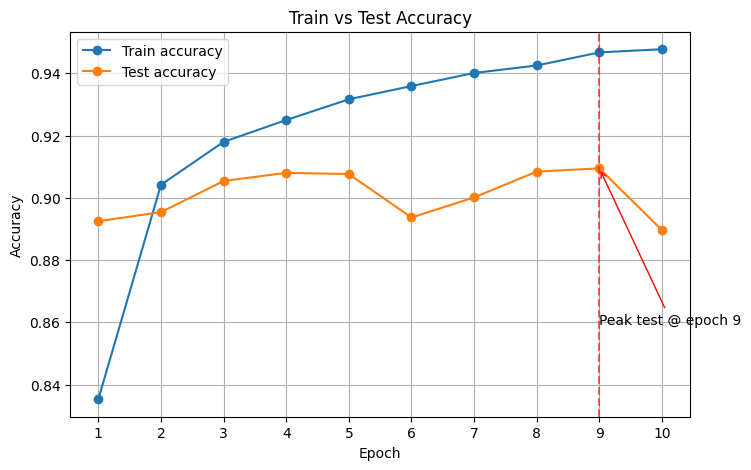


Epoch with largest train-test gap: 10 (gap=0.0581)


In [22]:
# Run a longer training loop (10 epochs) and plot train/test accuracy

# Ensure we start from a newly initialized model per the exercise instruction.
# Recreate model and optimizer so we don't continue training a previously
# trained instance.
import random
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Re-initialize model and optimizer for a fresh training run
model = TextClassificationModel(num_tokens, embed_dim, num_class).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=5.0)

n_epochs = 10
train_accs = []
test_accs = []

for epoch in range(1, n_epochs + 1):
    print(f"\n--- Epoch {epoch}/{n_epochs} ---")
    # Train for one epoch (uses the train_epoch function defined above)
    train_acc = train_epoch(model, train_dataloader, optimizer, criterion,
                            device=device, grad_clip=None, show_progress=False)

    # Evaluate on the held-out test set
    test_acc = evaluate(model, test_dataloader, criterion, device=device, show_progress=False)

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch} summary -> train_acc: {train_acc:.4f}, test_acc: {test_acc:.4f}")

# Plot training and test accuracy vs epoch
plt.figure(figsize=(8,5))
epochs = np.arange(1, n_epochs + 1)
plt.plot(epochs, train_accs, marker='o', label='Train accuracy')
plt.plot(epochs, test_accs, marker='o', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Mark the epoch where test accuracy peaked
peak_test_epoch = int(np.argmax(test_accs)) + 1
plt.axvline(peak_test_epoch, color='red', linestyle='--', alpha=0.6)
plt.annotate(f'Peak test @ epoch {peak_test_epoch}', xy=(peak_test_epoch, test_accs[peak_test_epoch-1]),
             xytext=(peak_test_epoch, max(test_accs) - 0.05),
             arrowprops=dict(arrowstyle='->', color='red'))

plt.show()

# Simple heuristic to indicate potential overfitting:
# - If test accuracy peaks earlier than final epoch and then decreases afterwards,
#   that suggests overfitting may begin after the peak.
# - Also report the epoch with the largest train/test gap.

peak_test = peak_test_epoch
if peak_test < n_epochs and test_accs[-1] < test_accs[peak_test - 1]:
    print(f"\nWarning: test accuracy peaked at epoch {peak_test} and decreased by the final epoch -> possible overfitting starting after epoch {peak_test}.")
else:
    print(f"\nTest accuracy peak at epoch {peak_test}. No clear post-peak decrease detected by this heuristic.")

# Report the epoch with the largest train-test gap (may indicate overfitting)
gaps = [t - v for t, v in zip(train_accs, test_accs)]
epoch_max_gap = int(np.argmax(gaps)) + 1
print(f"Epoch with largest train-test gap: {epoch_max_gap} (gap={gaps[epoch_max_gap-1]:.4f})")

# End of training & analysis cell

Notes / next steps

- This example builds a small vocabulary and trains a simple EmbeddingBag model for AG_NEWS.
- **Exercise:** modify the training loop to run for 10 epochs and plot the training and test accuracy versus epoch. Is there evidence of overfitting? At which epoch?  *Be sure to train a newly initialized model!*
- **Optional exercise:** read up on optimizers and introduce the Adam optimizer into the pipeline. See for example [https://pythonguides.com/adam-optimizer-pytorch/](https://pythonguides.com/adam-optimizer-pytorch/).  Compare the results trained using Adam with the default SGD optimizer.

Additional suggestions for better performance:
  - Use pretrained embeddings or larger embed_dim.
  - Use regularization, LR scheduling, or a different optimizer.
  - Use text preprocessing: lowercasing, stopword filtering, subword tokenization.
  - Explore transformer-based models with Hugging Face for state-of-the-art performance (session 3!)

